<a href="https://colab.research.google.com/github/arjunparmar/TUNEX/blob/main/Himanshu/Models/EmoDet1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!ls

sample_data


# Data Import from drive and imports

drive  sample_data


In [17]:
import pathlib
data_dir = 'drive/MyDrive/main'
data_dir = pathlib.Path(data_dir)

In [18]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [19]:
print(tf.__version__)

2.4.0


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

14730


In [23]:
emoFaces = list(data_dir.glob('0/*'))
img = PIL.Image.open(emoFaces[2])
img.size

(562, 762)

# Creating Dataset

In [24]:
batch_size = 32
img_height = 180
img_width = 180  #some basic values

In [25]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 17676 files belonging to 7 classes.
Using 14141 files for training.


In [26]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 17676 files belonging to 7 classes.
Using 3535 files for validation.


In [27]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6']


Mapping Emotions to the labels:
Afraid -> 0
Angry -> 1
Disgust -> 2
Happy -> 3
Nervous -> 4
Sad -> 5
Surprise -> 6



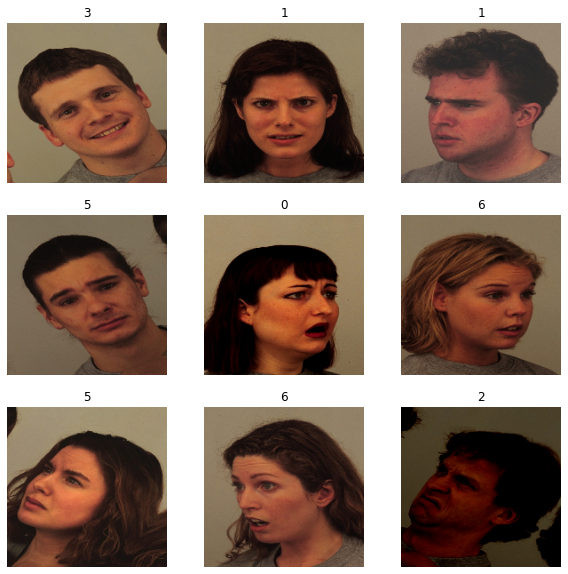

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [29]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [30]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [31]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.16746834 0.9659053


In [32]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [33]:
num_classes = 7

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [34]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [35]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
442/442 [==============================] - 9140s 21s/step - loss: 1.7578 - accuracy: 0.2681 - val_loss: 0.9200 - val_accuracy: 0.6552
Epoch 2/3
442/442 [==============================] - 515s 1s/step - loss: 0.7895 - accuracy: 0.7031 - val_loss: 0.5968 - val_accuracy: 0.7802
Epoch 3/3
442/442 [==============================] - 510s 1s/step - loss: 0.4389 - accuracy: 0.8391 - val_loss: 0.5167 - val_accuracy: 0.8221


In [38]:
model.fit(train_ds, validation_data=val_ds, epochs=25)

Epoch 1/25
442/442 [==============================] - 516s 1s/step - loss: 0.2003 - accuracy: 0.9301 - val_loss: 0.3668 - val_accuracy: 0.8747
Epoch 2/25
442/442 [==============================] - 515s 1s/step - loss: 0.1125 - accuracy: 0.9609 - val_loss: 0.2873 - val_accuracy: 0.9171
Epoch 3/25
442/442 [==============================] - 518s 1s/step - loss: 0.0690 - accuracy: 0.9769 - val_loss: 0.4114 - val_accuracy: 0.8883
Epoch 4/25
442/442 [==============================] - 514s 1s/step - loss: 0.0560 - accuracy: 0.9804 - val_loss: 0.3513 - val_accuracy: 0.9081
Epoch 5/25
442/442 [==============================] - 512s 1s/step - loss: 0.0504 - accuracy: 0.9830 - val_loss: 0.3216 - val_accuracy: 0.9157
Epoch 6/25
442/442 [==============================] - 513s 1s/step - loss: 0.0375 - accuracy: 0.9878 - val_loss: 0.2595 - val_accuracy: 0.9431
Epoch 7/25
442/442 [==============================] - 510s 1s/step - loss: 0.0569 - accuracy: 0.9799 - val_loss: 0.3002 - val_accuracy: 0.9321

We see that model is overfitting, It is having training accuracy of 0.99 and validation accuracy of 0.95. We must do some changes to reduce this error

But first let us check how model performs on some random images

In [45]:
Emotion = {
    '0' : 'Afraid',
    '1' : 'Angry',
    '2' : 'Disgust',
    '3' : 'Happy',
    '4' : 'Nervous',
    '5' : 'Sad',
    '6' : 'Surprise'
}

In [40]:
import keras.preprocessing

Trying to test it on images from webcam

In [47]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


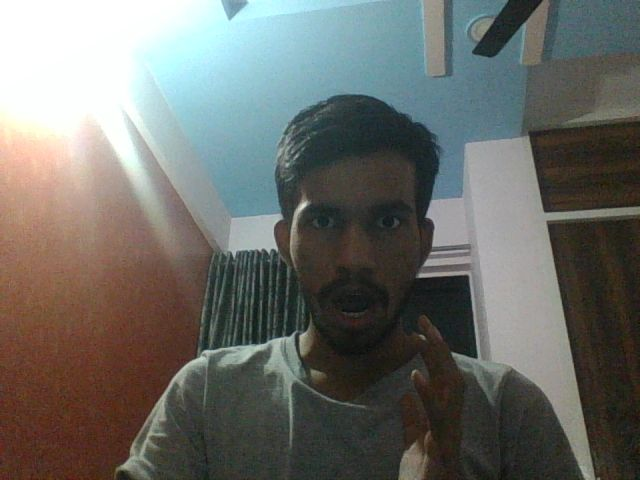

In [53]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [54]:
happy_url = "https://thumbs.dreamstime.com/z/portrait-attractive-cheerful-young-man-smiling-happy-face-human-expressions-emotions-model-beautiful-smile-blue-eyes-147751681.jpg"
happy_path = tf.keras.utils.get_file('Happy', origin=happy_url) #model detected this image to be surprise

filename1 = 'photo.jpg' #model detected 1st image to be disgust, I had done a neutral face
filename


img = keras.preprocessing.image.load_img(
    'photo.jpg', target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} Emotion with a {:.2f} percent confidence."
    .format(Emotion[class_names[np.argmax(score)]], 100 * np.max(score))
)


This image most likely belongs to Afraid Emotion with a 87.33 percent confidence.


Saving the model

In [63]:
!mkdir -p drive/MyDrive/tunex/models

In [64]:
model.save('drive/MyDrive/tunex/models/EmoDet1')

INFO:tensorflow:Assets written to: drive/MyDrive/tunex/models/EmoDet1/assets
